# Create a custom dataset of mathematical formulas

The data used to create this dataset are the MNIST dataset (digits 0 to 9) and a subset of the plus and minus signs from the [Handwritten Math Symbols](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols) dataset.

In [151]:
import numpy as np
import struct
from array import array
from os.path import join
from os import listdir
import json
import cv2
from google.colab.patches import cv2_imshow
import random

## Prepare the data

In [152]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the MNIST data

The dataset was downloaded from [lecun.com](https://yann.lecun.com/exdb/mnist/). Unfortunatly the site seems to be password protected by now.

In [153]:
# Dataloader adjusted from this code: https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook
class MnistDataloader(object):
    def __init__(self, images_filepath, labels_filepath):
        self.images_filepath = images_filepath
        self.labels_filepath = labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        num_examples = size
        for i in range(num_examples):
            images.append([0] * rows * cols)
        for i in range(num_examples):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x, y = self.read_images_labels(self.images_filepath, self.labels_filepath)
        return (x, y)

In [154]:
# Create the file paths for the MNIST data
input_path = '/content/drive/MyDrive/dlproject'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

In [155]:
# Load the MNIST training data
train_mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath)
(x_train, y_train) = train_mnist_dataloader.load_data()

# Load the MNIST evaluation/test data
test_mnist_dataloader = MnistDataloader(test_images_filepath, test_labels_filepath)
(x_test, y_test) = test_mnist_dataloader.load_data()

### Prepare the MNIST data

In [158]:
# Categorize the indices of the training dataset digit images
train_digit_indices = {}

for i in range(10):
  train_digit_indices[str(i)] = []

for i in range(60000):
  train_digit_indices[str(y_train[i])].append(i)

In [159]:
# Categorize the indices of the evaluation/test dataset digit images
test_digit_indices = {}

for i in range(10):
  test_digit_indices[str(i)] = []

for i in range(10000):
  test_digit_indices[str(y_test[i])].append(i)

### Load the prepared plus and minus sign images

In [161]:
# Create the file paths for the plus and minus sign images prepared by the Single-Sign-Creation notebook
input_path = '/content/drive/MyDrive/deeplearning'
train_plus_sign_path = join(input_path, 'sign-images/train-plus-signs')
train_minus_sign_path = join(input_path, 'sign-images/train-minus-signs')
test_plus_sign_path = join(input_path, 'sign-images/test-plus-signs')
test_minus_sign_path = join(input_path, 'sign-images/test-minus-signs')

In [162]:
# Save the file names of the images
train_plus_indices = listdir(train_plus_sign_path)
train_minus_indices = listdir(train_minus_sign_path)
test_plus_indices = listdir(test_plus_sign_path)
test_minus_indices = listdir(test_minus_sign_path)

## Functions used to create the dataset

In [156]:
# Returns the index of the first row containing a non-zero value (pixel)
def get_upper_border(img):
  for i in range(len(img)):
    for j in range(len(img[i])):
      if not img[i][j] == 0:
          return i

# Returns the index of the last row containing a non-zero value (pixel)
def get_lower_border(img):
  for i in range(len(img)-1, 0, -1):
    for j in range(len(img[i])):
      if not img[i][j] == 0:
          return i

# Returns the index of the first column containing a non-zero value (pixel)
def get_left_border(img):
  for j in range(len(img[0])):
    for i in range(len(img)):
      if not img[i][j] == 0:
          return j

# Returns the index of the last column containing a non-zero value (pixel)
def get_right_border(img):
  for j in range(len(img[0])-1, 0, -1):
    for i in range(len(img)):
      if not img[i][j] == 0:
          return j

In [157]:
# Removes the whitespace around the signs and digits
def get_img(img_sample):
  upper_border = get_upper_border(img_sample)
  lower_border = get_lower_border(img_sample)
  left_border = get_left_border(img_sample)
  right_border = get_right_border(img_sample)

  img_reduced_rows = img_sample[upper_border:lower_border+1]
  img = []
  for row in img_reduced_rows:
    img.append(row[left_border:right_border+1])
  
  return img

### Create formula strings

In [163]:
# Function to create formula string of arbitrary length that start and end with a digit and have at least one operator sign
def generate_formula_str(str_len):
  # Start with digit
  formula_str = str(random.randint(1,9))

  # Add signs and digits (digit probability descends until a sign was added)
  max_num_len = 5
  x = max_num_len

  for i in range(1, str_len-1):
    if formula_str[i-1] in ['+', '-']:
      formula_str += str(random.randint(1, 9))
    else: 
      if random.randint(1,x) == 1:
        if random.randint(1,2) == 1:
          formula_str += '+'
        else:
          formula_str += '-'
        x = max_num_len
      else:
        formula_str += str(random.randint(0, 9))
        x -= 1

  # End with digit
  formula_str += str(random.randint(0, 9))
  return formula_str

### Create formula images

In [164]:
# Define the valid chars in the formula strings
valid_chars = [str(x) for x in range(10)] + ['+', '-']

In [166]:
# Turn the formula string into an image with random digit and sign images chosen from the given datasets
def create_formula_img(formula_str, images=[], valid_chars=[], width=384, height=48, digit_indices=[], plus_indices=[], minus_indices=[], plus_sign_path=[], minus_sign_path=[]):
  # The formula starts with a random offset from the top left corner
  num_x = random.randint(8, 12)
  num_y = random.randint(8, 12)
  num_width = 0
  num_height = 0
  
  # Init the formula image
  formula_img = np.zeros((height, width, 1), dtype=np.uint8)

  # Init the metadata for this image
  metadata = dict(img_name='', formula_str=formula_str, digits=[])

  for char in formula_str:
    # Random offset of each digit and sign, so the images aren't in one straight line
    x_offset = random.randint(2, 4)
    y_offset = random.randint(0, 3)

    # Load the sign/digit image
    if char in valid_chars:
      if char == '+':
        rand_index = random.randint(0, len(plus_indices)-1)
        image = cv2.imread(join(plus_sign_path, plus_indices[rand_index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = get_img(image)
        image = np.asarray(image, dtype=np.uint8)
        y_offset += random.randint(-2,0) # Correction offset since + signs tend to be lower than the average digit
      elif char == '-':
        rand_index = random.randint(0, len(minus_indices)-1)
        image = cv2.imread(join(minus_sign_path, minus_indices[rand_index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = get_img(image)
        image = np.asarray(image, dtype=np.uint8)
        y_offset += random.randint(2,4) # Correction offset since - signs tend to be higher than the average digit
      else:
        rand_index = random.randint(0, len(digit_indices[char])-1)
        image = images[digit_indices[char][rand_index]]
        image = get_img(image)
        image = np.asarray(image, dtype=np.uint8)

      # Get image width and height without whitespace
      num_width = image.shape[1]
      num_height = image.shape[0]

      # Calculate the positions of the 4 corners of the number (useful for Object Recognition tasks not used by us)
      x_min = num_x + x_offset
      x_max = num_x + x_offset + num_width
      y_min = num_y + y_offset
      y_max = num_y + y_offset + num_height

      # Append the information to the metadata
      metadata['digits'].append(dict(x_min = x_min, x_max = x_max, y_min = y_min, y_max = y_max))

      # Add the digit/sign image to the formula image
      add_img = np.maximum(formula_img[y_min: y_max, x_min: x_max, 0], image)
      formula_img[y_min: y_max, x_min: x_max, 0] = add_img

      # Change x position for the next digit/sign
      num_x = num_x + num_width + x_offset

  return formula_img, metadata

## Create the dataset

In [167]:
# Dictionary containing the metadata of the created images
formulas = dict(train_formulas=[], test_formulas=[])

### Create the training dataset

0
6945-8+207


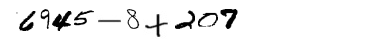

100
72-64641-59


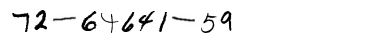

200
8602-7


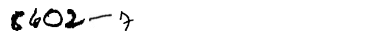

300
8754-3141


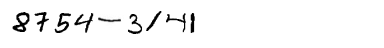

400
9-28-12691-0


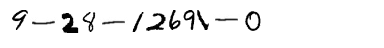

500
2660-1-65760


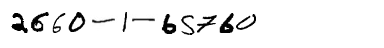

600
4935+693757


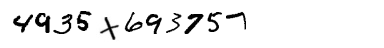

700
2891+356


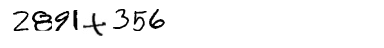

800
68025+2-641


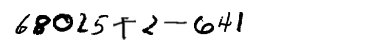

900
86-566


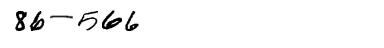

1000
4+84-98423


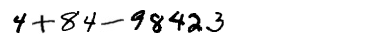

1100
764-87-8394


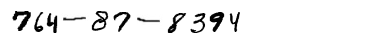

1200
530-4-241490


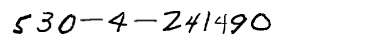

1300
5397-6-95


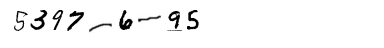

1400
30190+23


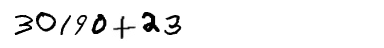

1500
989+3-86


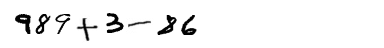

In [168]:
formula_set = set()

n = 0
while not len(formula_set) == 1600:
  # Generate a formula string of random length
  formula_str = generate_formula_str(random.randint(6, 12))
  # Don't create duplicate formula string
  if not formula_str in formula_set:
    # Only use formula strings with at least one + or -
    if '+' in formula_str or '-' in formula_str:
      # Create image and metadata and save the information
      image, metadata = create_formula_img(formula_str, images=x_train, valid_chars=valid_chars, digit_indices=train_digit_indices, plus_indices=train_plus_indices, minus_indices=train_minus_indices, plus_sign_path=train_plus_sign_path, minus_sign_path=train_minus_sign_path)
      img_name = 'train_formula_' + str(n) + '.jpg'
      metadata['img_name'] = img_name
      formulas['train_formulas'].append(metadata)
      formula_set.add(formula_str)
      cv2.imwrite(join('drive/MyDrive/deeplearning/formula-dataset/train', img_name), cv2.bitwise_not(image))
      # Show an example image every 100 images
      if n % 100 == 0:
        print(n)
        print(formula_str)
        cv2_imshow(cv2.bitwise_not(image))
      n += 1

### Create the evaluation/test dataset

0
7331+95+9


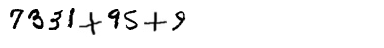

100
8-70+2-2


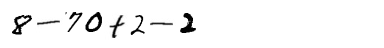

200
41379+3383


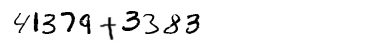

300
49-5+84552


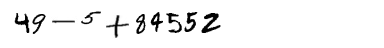

In [169]:
formula_set = set()

n = 0
while not len(formula_set) == 400:
  # Generate a formula string of random length
  formula_str = generate_formula_str(random.randint(6, 12))
  # Don't create duplicate formula string
  if not formula_str in formula_set:
    # Only use formula strings with at least one + or -
    if '+' in formula_str or '-' in formula_str:
      # Create image and metadata and save the information
      image, metadata = create_formula_img(formula_str, images=x_test, valid_chars=valid_chars, digit_indices=test_digit_indices, plus_indices=test_plus_indices, minus_indices=test_minus_indices, plus_sign_path=test_plus_sign_path, minus_sign_path=test_minus_sign_path)
      img_name = 'test_formula_' + str(n) + '.jpg'
      metadata['img_name'] = img_name
      formulas['test_formulas'].append(metadata)
      formula_set.add(formula_str)
      cv2.imwrite(join('drive/MyDrive/deeplearning/formula-dataset/test', img_name), cv2.bitwise_not(image))
      # Show an example image every 100 images
      if n % 100 == 0:
        print(n)
        print(formula_str)
        cv2_imshow(cv2.bitwise_not(image))
      n += 1

### Save the metadata

In [170]:
# Save the metadata as JSON file
with open(join('drive/MyDrive/deeplearning/formula-dataset', 'formula_metadata.json'), 'w') as f:
  json.dump(formulas, f)